In [1]:
# Useful commamnds
!rm -rf /kaggle/working/*

Reference Github: https://github.com/BreezeWhite/oemer

In [2]:
import numpy as np
from PIL import Image
import xml.etree.ElementTree as ET
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

doremi_dir = "/kaggle/input/doremi-raw-dataset/DoReMi_v1/"
IMAGE_WIDTH = 2475
IMAGE_HEIGHT = 1577

# Sample data

Importing sample image from the [DoReMi](https://github.com/steinbergmedia/DoReMi/?tab=readme-ov-file#OMR-metadata) dataset.

In [3]:
img_path = doremi_dir + 'Images/Alkan - Posement-001.png'
image = Image.open(img_path)

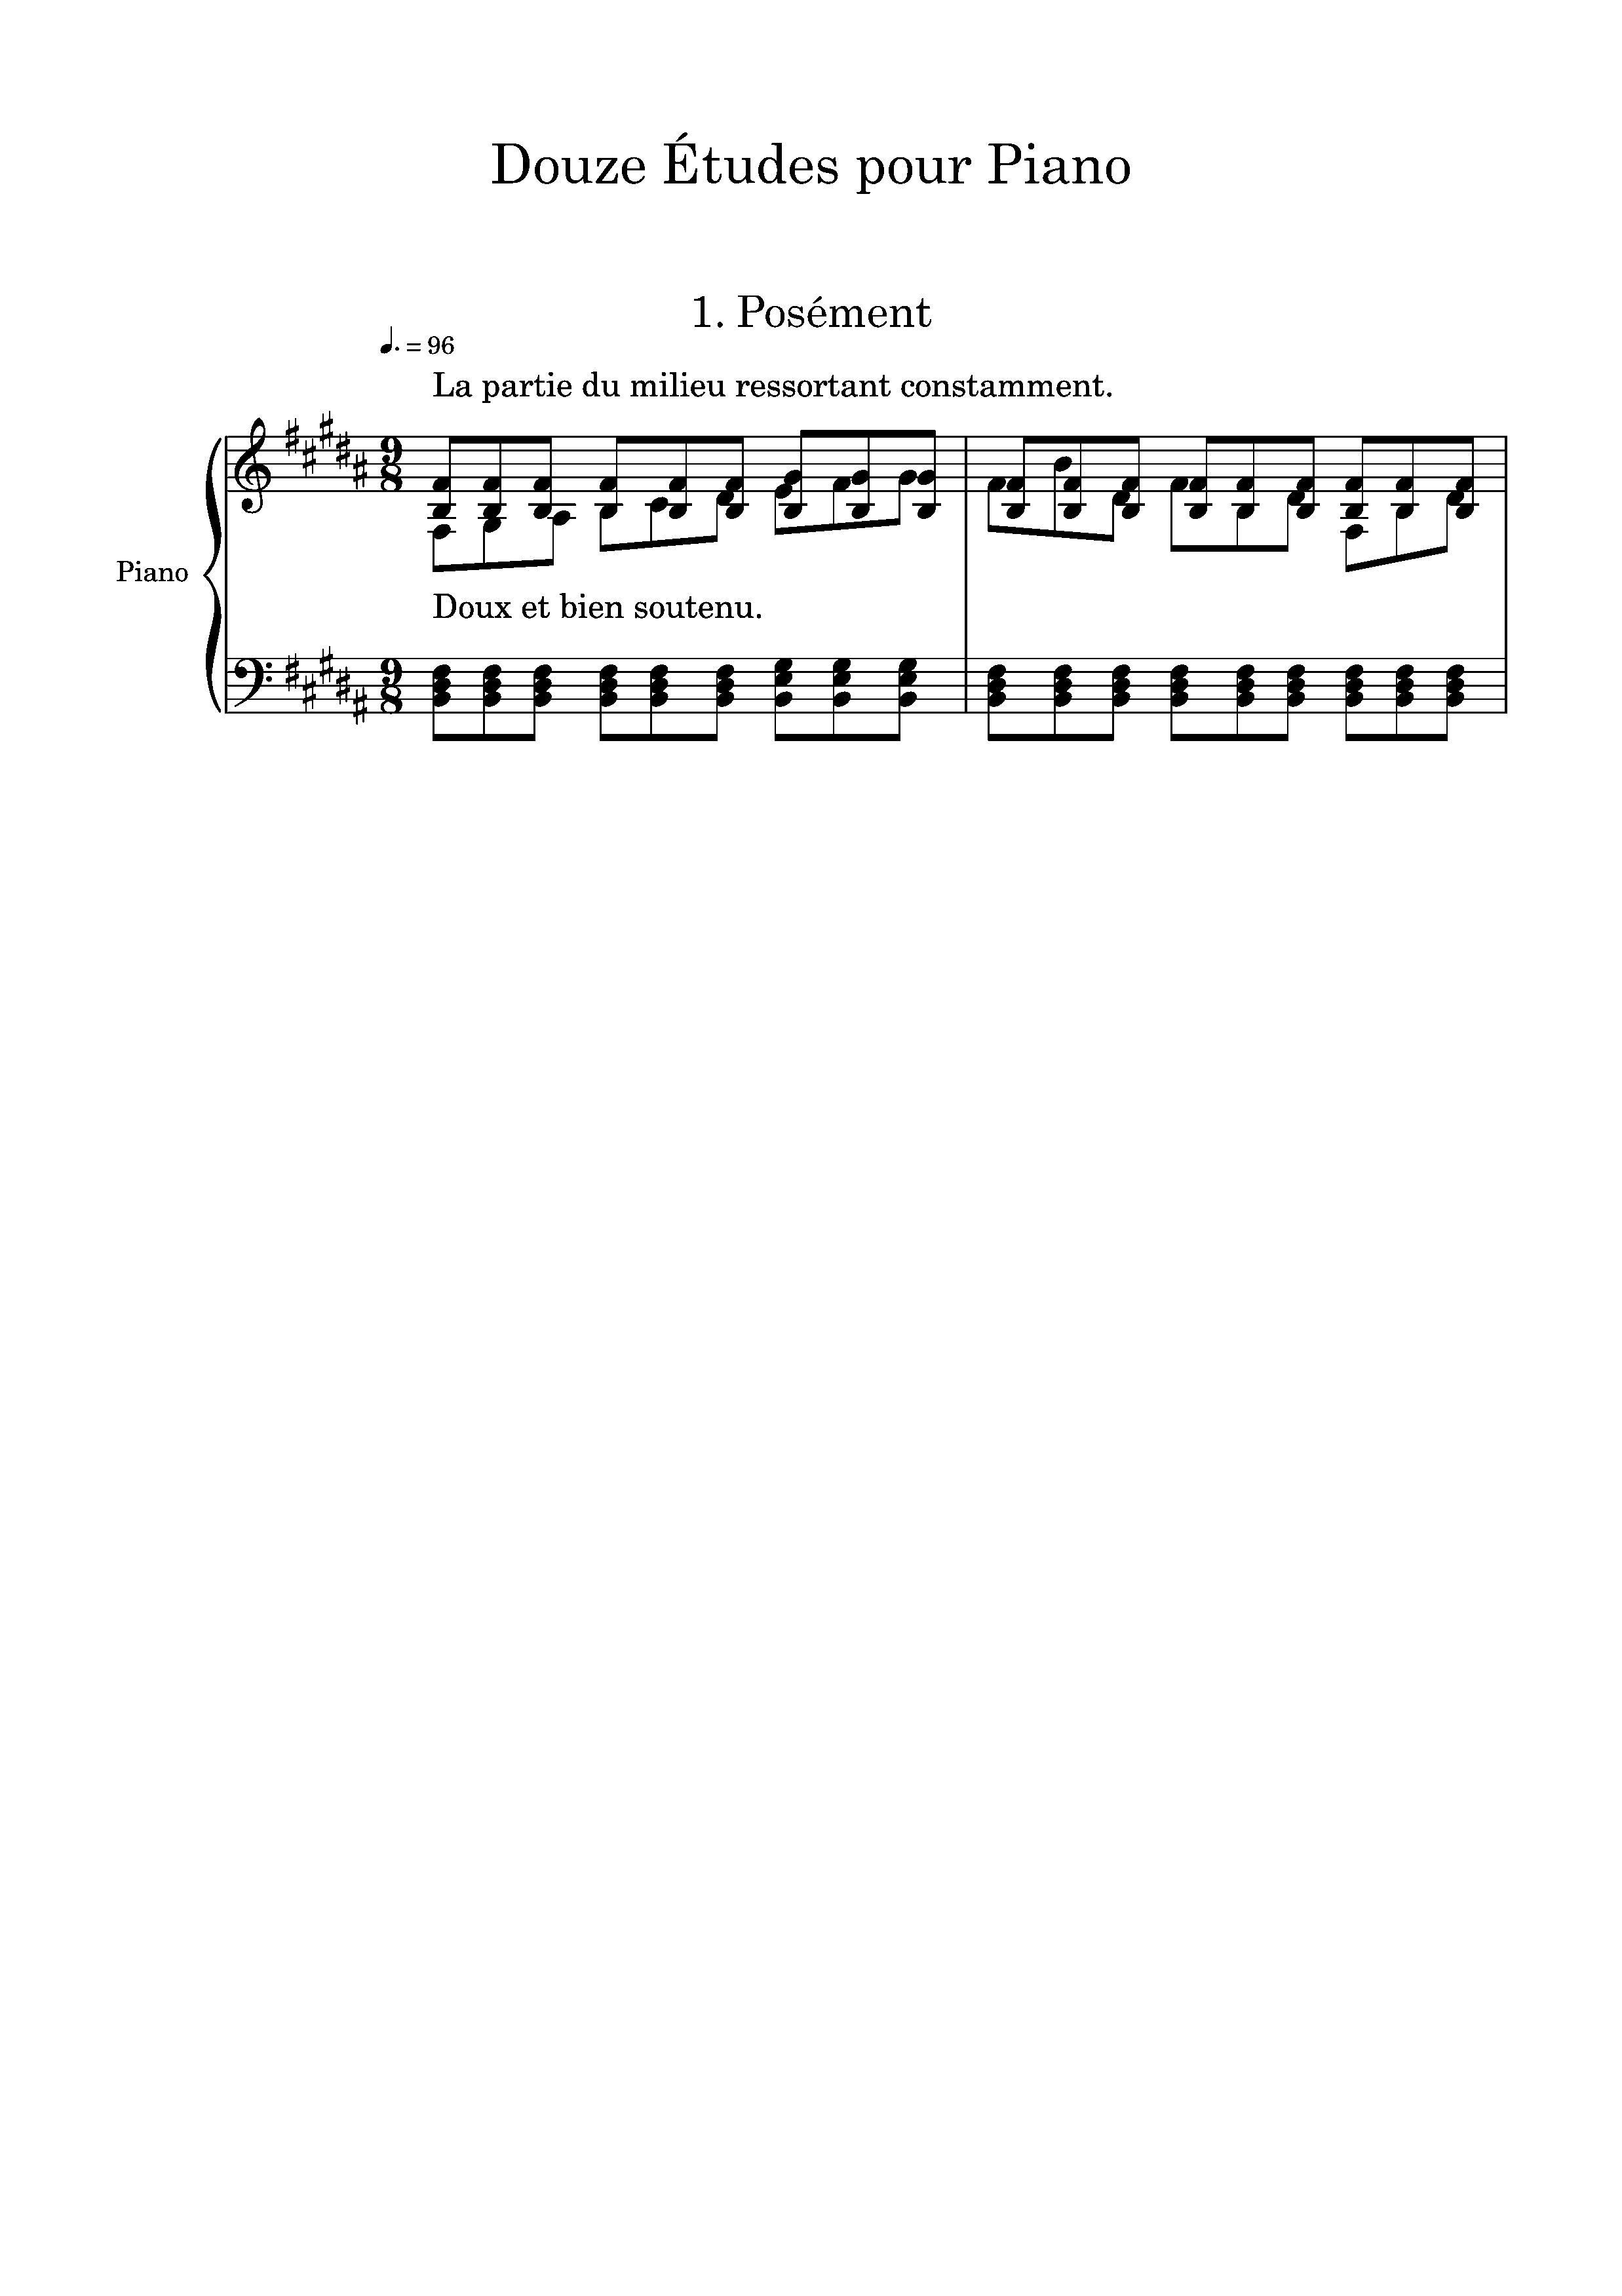

In [4]:
image

In [5]:
file_path = doremi_dir + 'OMR_XML/Alkan - Posement-layout-0-muscima.xml'
with open(file_path, 'r') as file:
    content = file.read(200)
    print(content)

<?xml version="1.0" encoding="utf-8"?>
<Pages><Page pageIndex="0"><Nodes><Node><Id>230</Id><ClassName>accidentalSharp</ClassName><Top>1049</Top><Left>539</Left><Width>21</Width><Height>59</Height><Mas


# Preprocessing Data

## Cropping Input Image
To adjust the size of our data, we wrote a python script to crop the input image. 

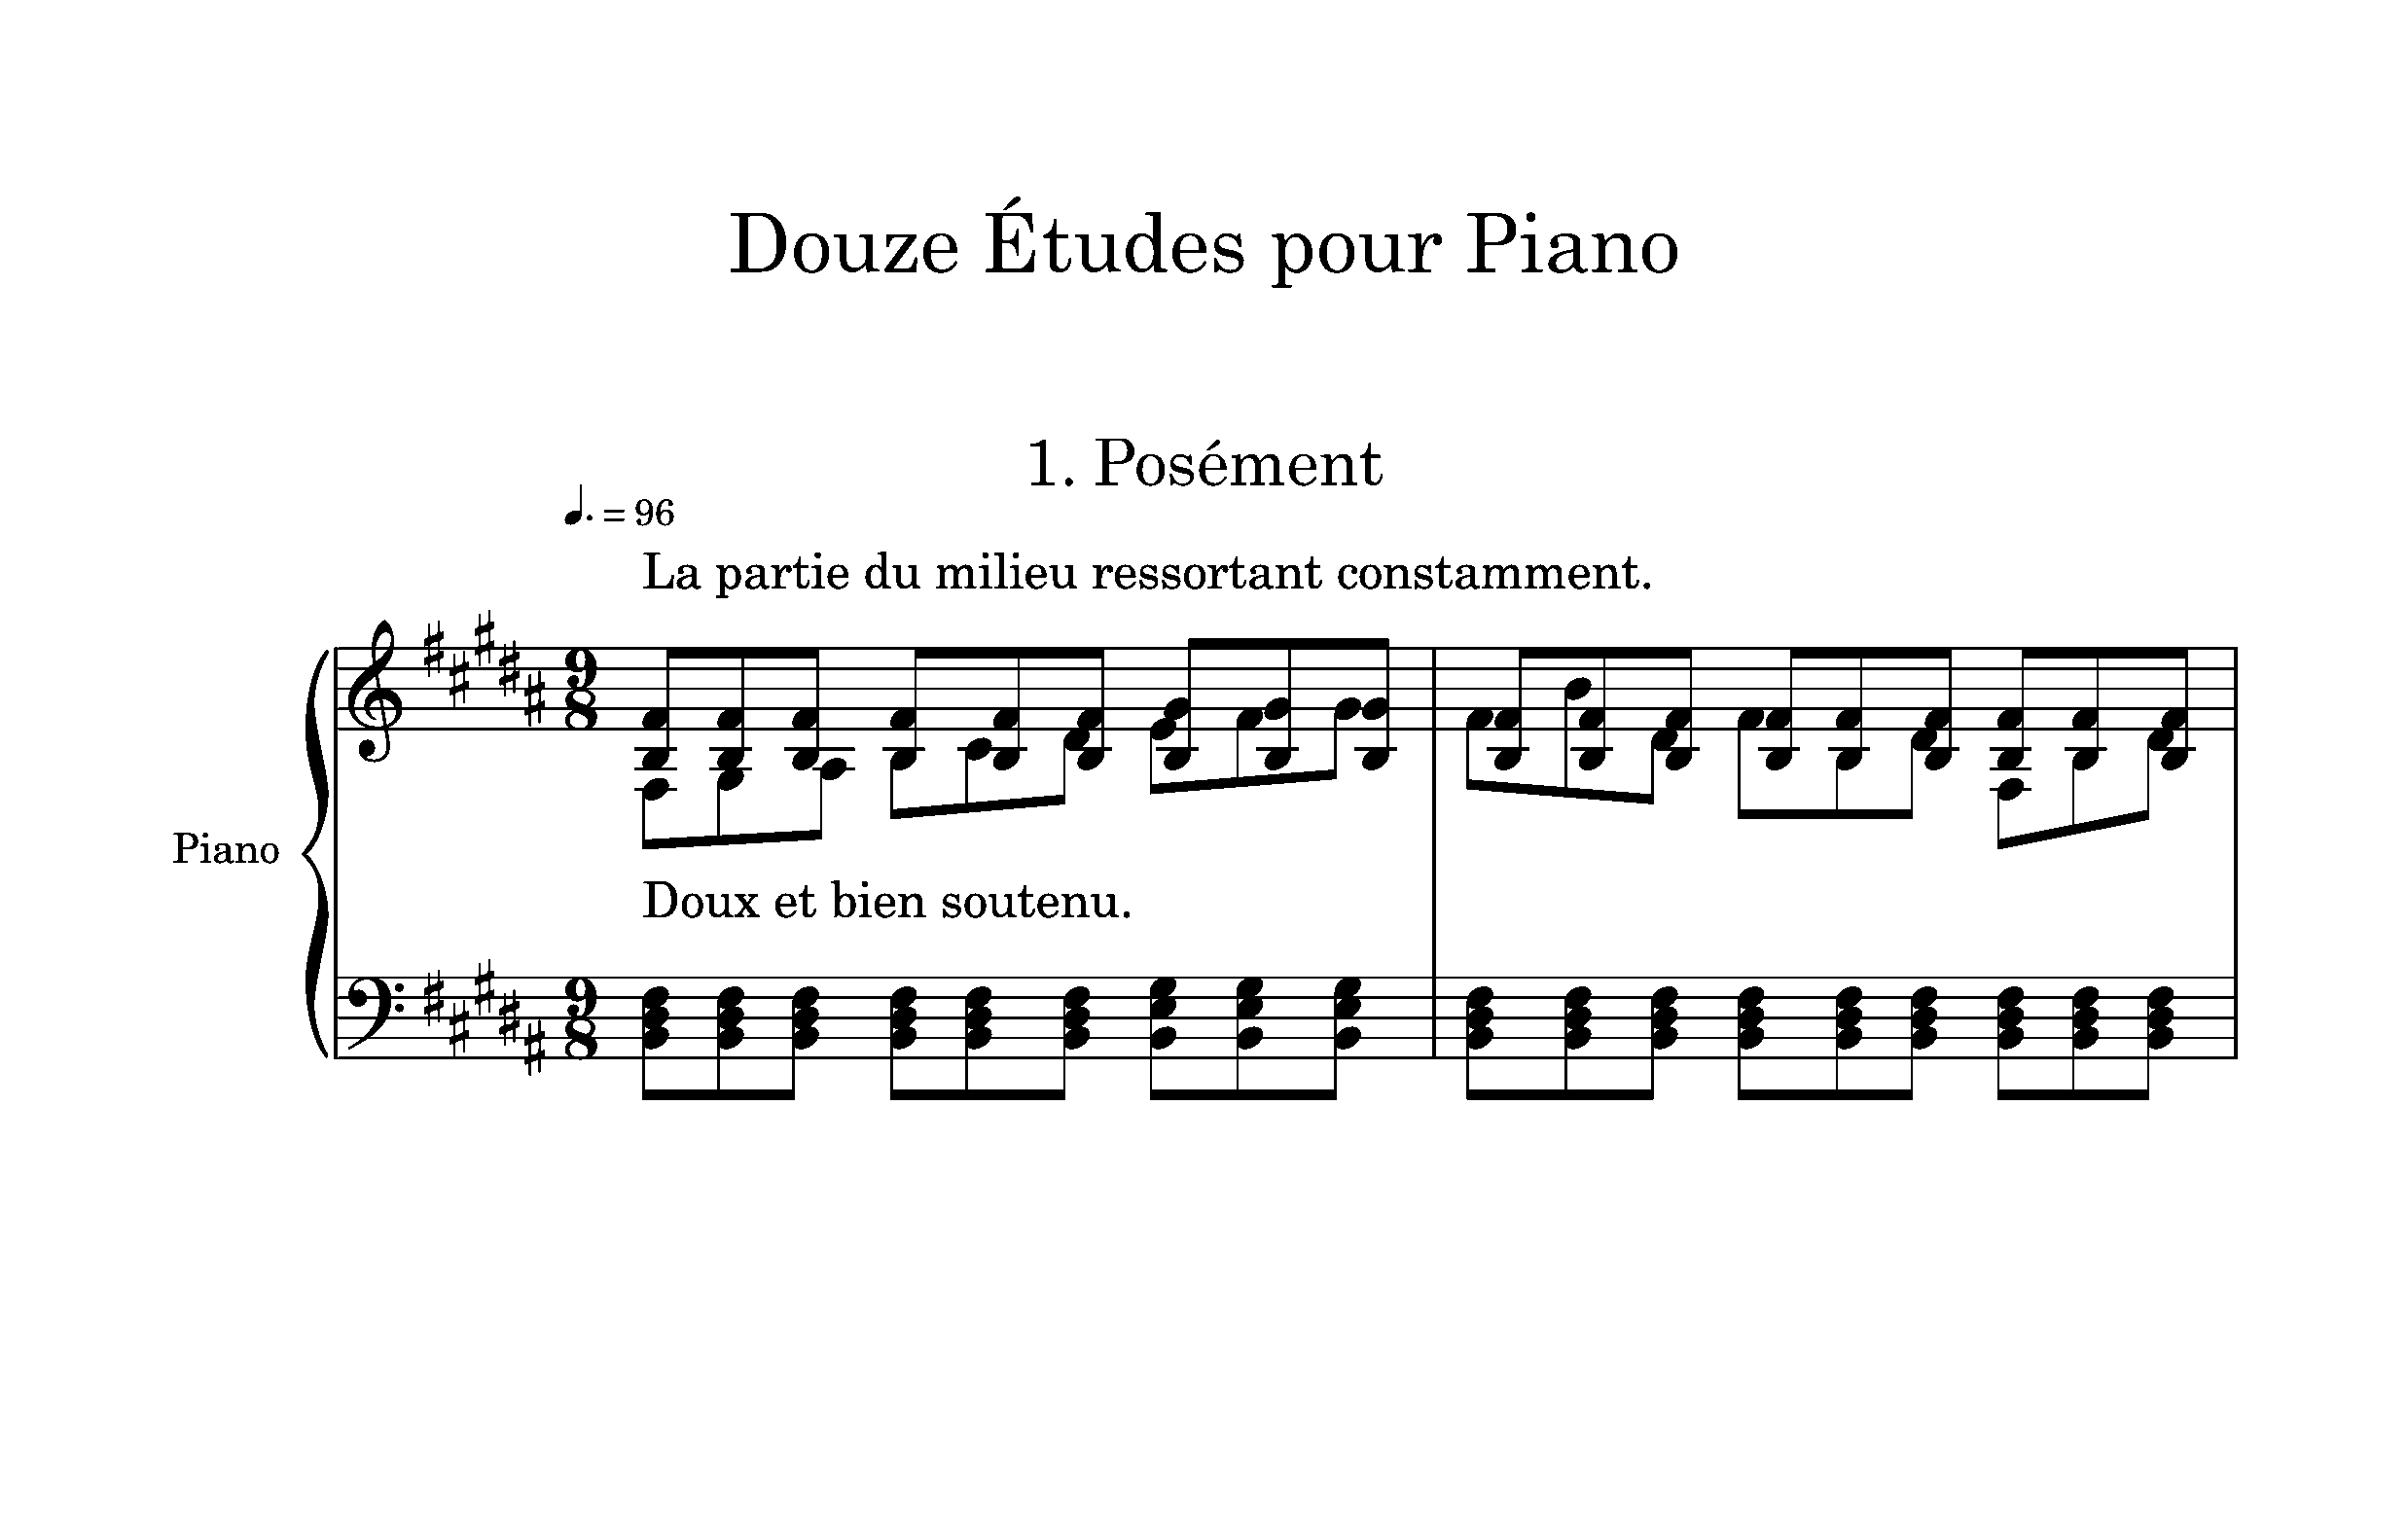

In [6]:
from IPython.display import display

def crop_top_half(image_path):
    """
    Crops the top half of the image.

    Parameters:
    - image_path: str, path to the input image.

    Returns:
    - cropped_image: PIL.Image.Image, the cropped top half of the image.
    """
    image = Image.open(image_path)

    width, height = image.size
    crop_height = height * 0.45
    crop_box = (0, 0, width, crop_height)
    cropped_image = image.crop(crop_box)
    
    return cropped_image

# Example usage
input_image_path = doremi_dir + 'Images/Alkan - Posement-001.png'
cropped_image = crop_top_half(input_image_path)

display(cropped_image)

## Staffline Extraction
First, we will extract stafflines. This step is the most important as the music scores are determined by their relative position to the stafflines. We will extract the following information for each staffline, which are fundamental for the later parts of this project. 

In [7]:
# example output of staff extraction
# Staff {
#     Center: 0.0 # y-center 
#     Upper bound: 150 # upper bound of the block
#     Lower bound: 200 # lower bound of the block
#     Unit size: 5.0 # distance between each stafflines
#     Track: 1 # for a two-handed piano score, track 1 would be for the left hand and track 2 would be for right hand
#     Group: 3 # for a two-handed piano score, two tracks are grouped into one
# }

In [8]:
class Line:
    def __init__(self) -> None:
        self.points = [] # stores the (x,y) pixels that make up the line
        self.label = "" # FIRST, SECOND, THIRD, FOURTH, FIFTH

    def add_point(self, x:int, y:int) -> None:
        self.points.append((x,y))
        self.y_center = None
        self.upper = None
        self.lower = None
        self.x_center = None
        self.x_left = None
        self.x_right = None 
        

In [9]:
class Staff:
    def __init(self) -> None:
        self.lines = List[Line]
        self.track = None
        self.group = None

# Boundary Thought Process: 

In [10]:
class Staff:
    def __init__(self, center: float, upper_bound: int, lower_bound: int, unit_size: float, track: int):
        self.center = center
        self.upper_bound = upper_bound
        self.lower_bound = lower_bound
        self.unit_size = unit_size
        self.track = track

    def __repr__(self):
        return (
            "Staff {\n"
            f"    Center: {self.center:.1f}\n"
            f"    Upper bound: {self.upper_bound}\n"
            f"    Lower bound: {self.lower_bound}\n"
            f"    Unit size: {self.unit_size:.1f}\n"
            f"    Track: {self.track}\n"
            "}"
        )

Staff {
    Center: 707.2
    Upper bound: 594
    Lower bound: 821
    Unit size: 20.8
    Track: 1
}
Staff {
    Center: 1045.4
    Upper bound: 933
    Lower bound: 1157
    Unit size: 20.5
    Track: 2
}


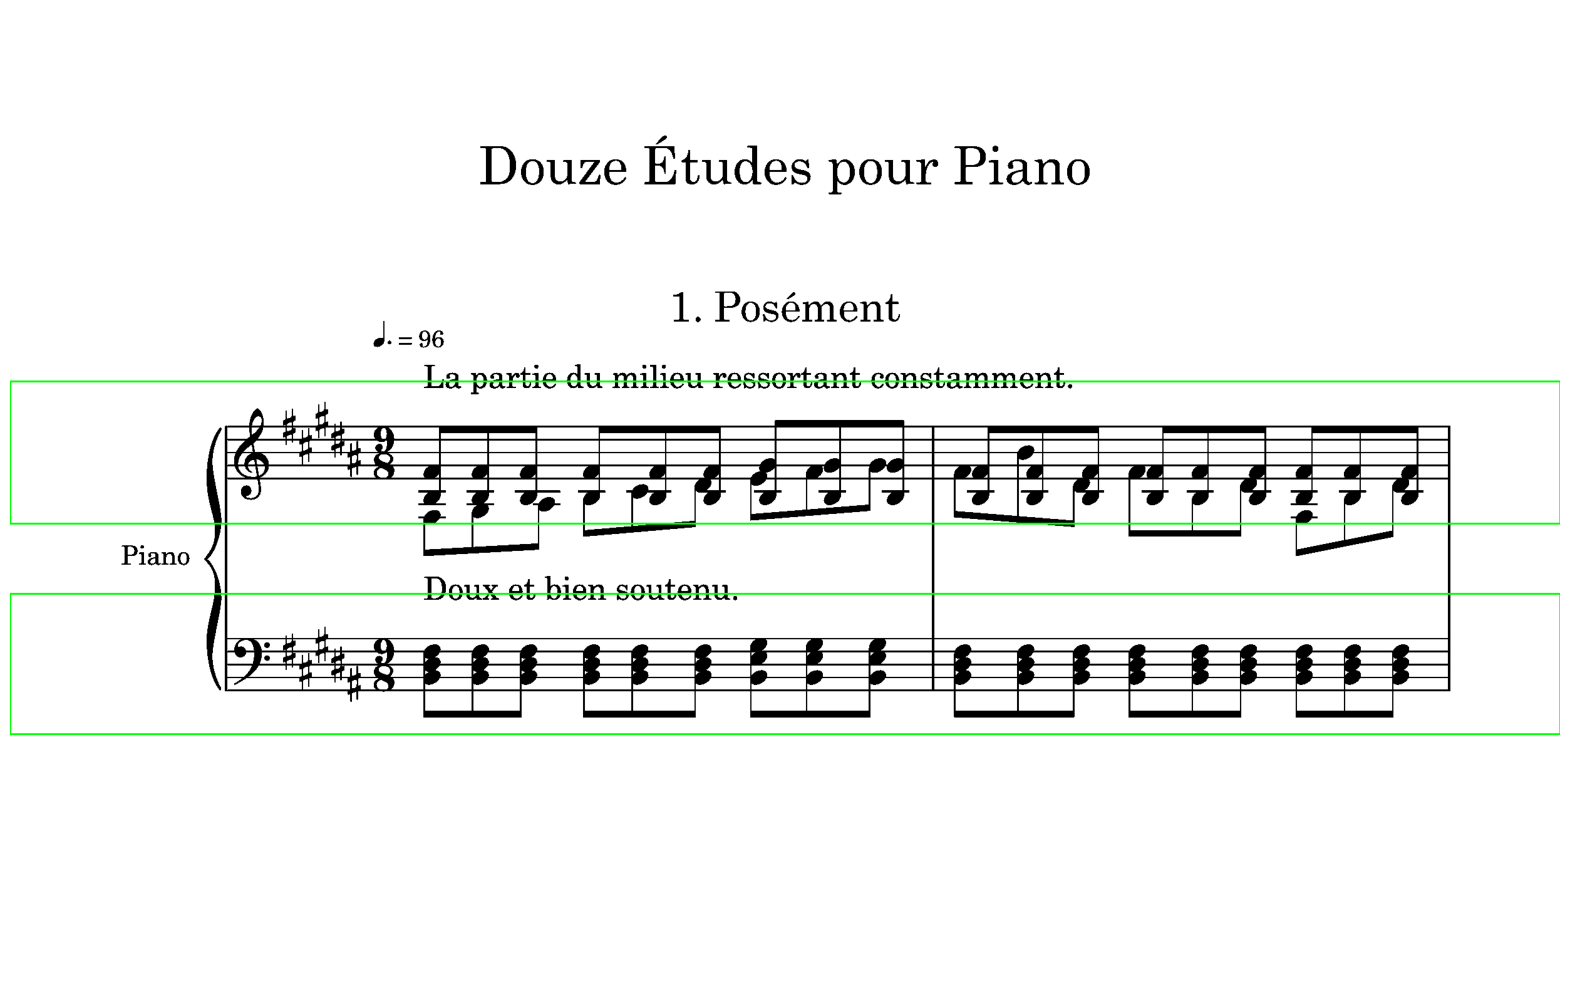

In [11]:
import cv2
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

# Step 0: Convert grayscale
image_gray = cropped_image.convert("L")
image_np = np.array(image_gray)

# Step 1: Binarize image
_, binary = cv2.threshold(image_np, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Step 2: Horizontal projection
horizontal_projection = np.sum(binary, axis=1)

# Step 3: Detect staffline peaks
peaks, _ = find_peaks(horizontal_projection, height=np.max(horizontal_projection) * 0.5, distance=5)

# Step 4: Group into staves (5 lines per group)
grouped_staffs = []
for i in range(0, len(peaks) - 4, 5):
    group = peaks[i:i+5]
    grouped_staffs.append(group)

# Step 5: Convert grayscale to RGB for drawing
image_color = np.stack([image_np]*3, axis=-1)

# Step 6: Draw bounding boxes and print structured output
staff_bounds = []
staff_bounds = []
staff_objects = []

for i, group in enumerate(grouped_staffs):
    y_center = float(np.mean(group))
    unit_size = float(np.mean(np.diff(group)))
    padding = int(unit_size * 3.5)

    y_min = int(np.min(group) - padding)
    y_max = int(np.max(group) + padding)
    track = i % 2 + 1

    staff = Staff(
        center=y_center,
        upper_bound=y_min,
        lower_bound=y_max,
        unit_size=unit_size,
        track=track
    )
    staff_objects.append(staff)
    staff_bounds.append((y_min, y_max))

    cv2.rectangle(image_color, (0, y_min), (image_np.shape[1], y_max), (0, 255, 0), 2)
    print(staff)


# Step 7: Show image with bounding boxes
plt.figure(figsize=(20, 20))
plt.imshow(image_color)
plt.axis("off")
plt.show()

# OMR_XML Preprocessng

In [12]:
import re
import pprint

def natural_key(string):
    return [int(s) if s.isdigit() else s.lower() for s in re.split('(\d+)', string)]

#Sorts Images and Parsed_by_page_omr_xml directories
image_list = os.listdir(doremi_dir+ "Images")
omr_xml_list =  os.listdir(doremi_dir + "Parsed_by_page_omr_xml")
image_list.sort(key=natural_key)
omr_xml_list.sort(key=natural_key)

#Matches each .png file to their respective omr_xml file
image_to_omr = {img: omr for img, omr in zip(image_list, omr_xml_list)}
#pprint.pprint(image_to_omr)


In [13]:
#To view an image [0,5217]
key_list = list(image_to_omr.keys())
image_path = os.path.join(doremi_dir, "Images", key_list[5217])
image = Image.open(image_path)
#image

In [14]:
class Note:
    def __init__(self, class_name: str, top: int, left: int, width: int, height: int):
        self.class_name = class_name
        self.top = top
        self.left = left
        self.width = width
        self.height = height
    def gather_coordinates(self):
        return [self.top, self.left, self.width, self.height]
    def create_box(self):
        return [(self.left, self.top), (self.left + self.width, self.top + self.height)]



In [15]:
import xml.etree.ElementTree as ET

image_to_notes = {}
for key in key_list:
# Parse the XML file
    xml_path = os.path.join(doremi_dir, "Parsed_by_page_omr_xml", image_to_omr[key])
    tree = ET.parse(xml_path)  # replace with your actual file path
    root = tree.getroot()
# Define target classnames
    target_classes = {'noteheadBlack', 'noteheadHalf', 'noteheadWhole'}

# Collect matching nodes
    matching_nodes = []

# Loop through all <Node> elements
    for node in root.findall('.//Node'):
        class_name = node.find('ClassName')
        if class_name is not None and class_name.text in ('noteheadBlack', 'noteheadHalf', 'noteheadWhole'):
            matching_nodes.append(node)


# Print results
    final_notes = []
    for match in matching_nodes:
        note = Note(match.find("ClassName").text, int(match.find("Top").text), int(match.find("Left").text), int(match.find("Width").text), int(match.find("Height").text))
        final_notes.append(note)
    image_to_notes[key] = final_notes
#pprint.pprint(image_to_notes)


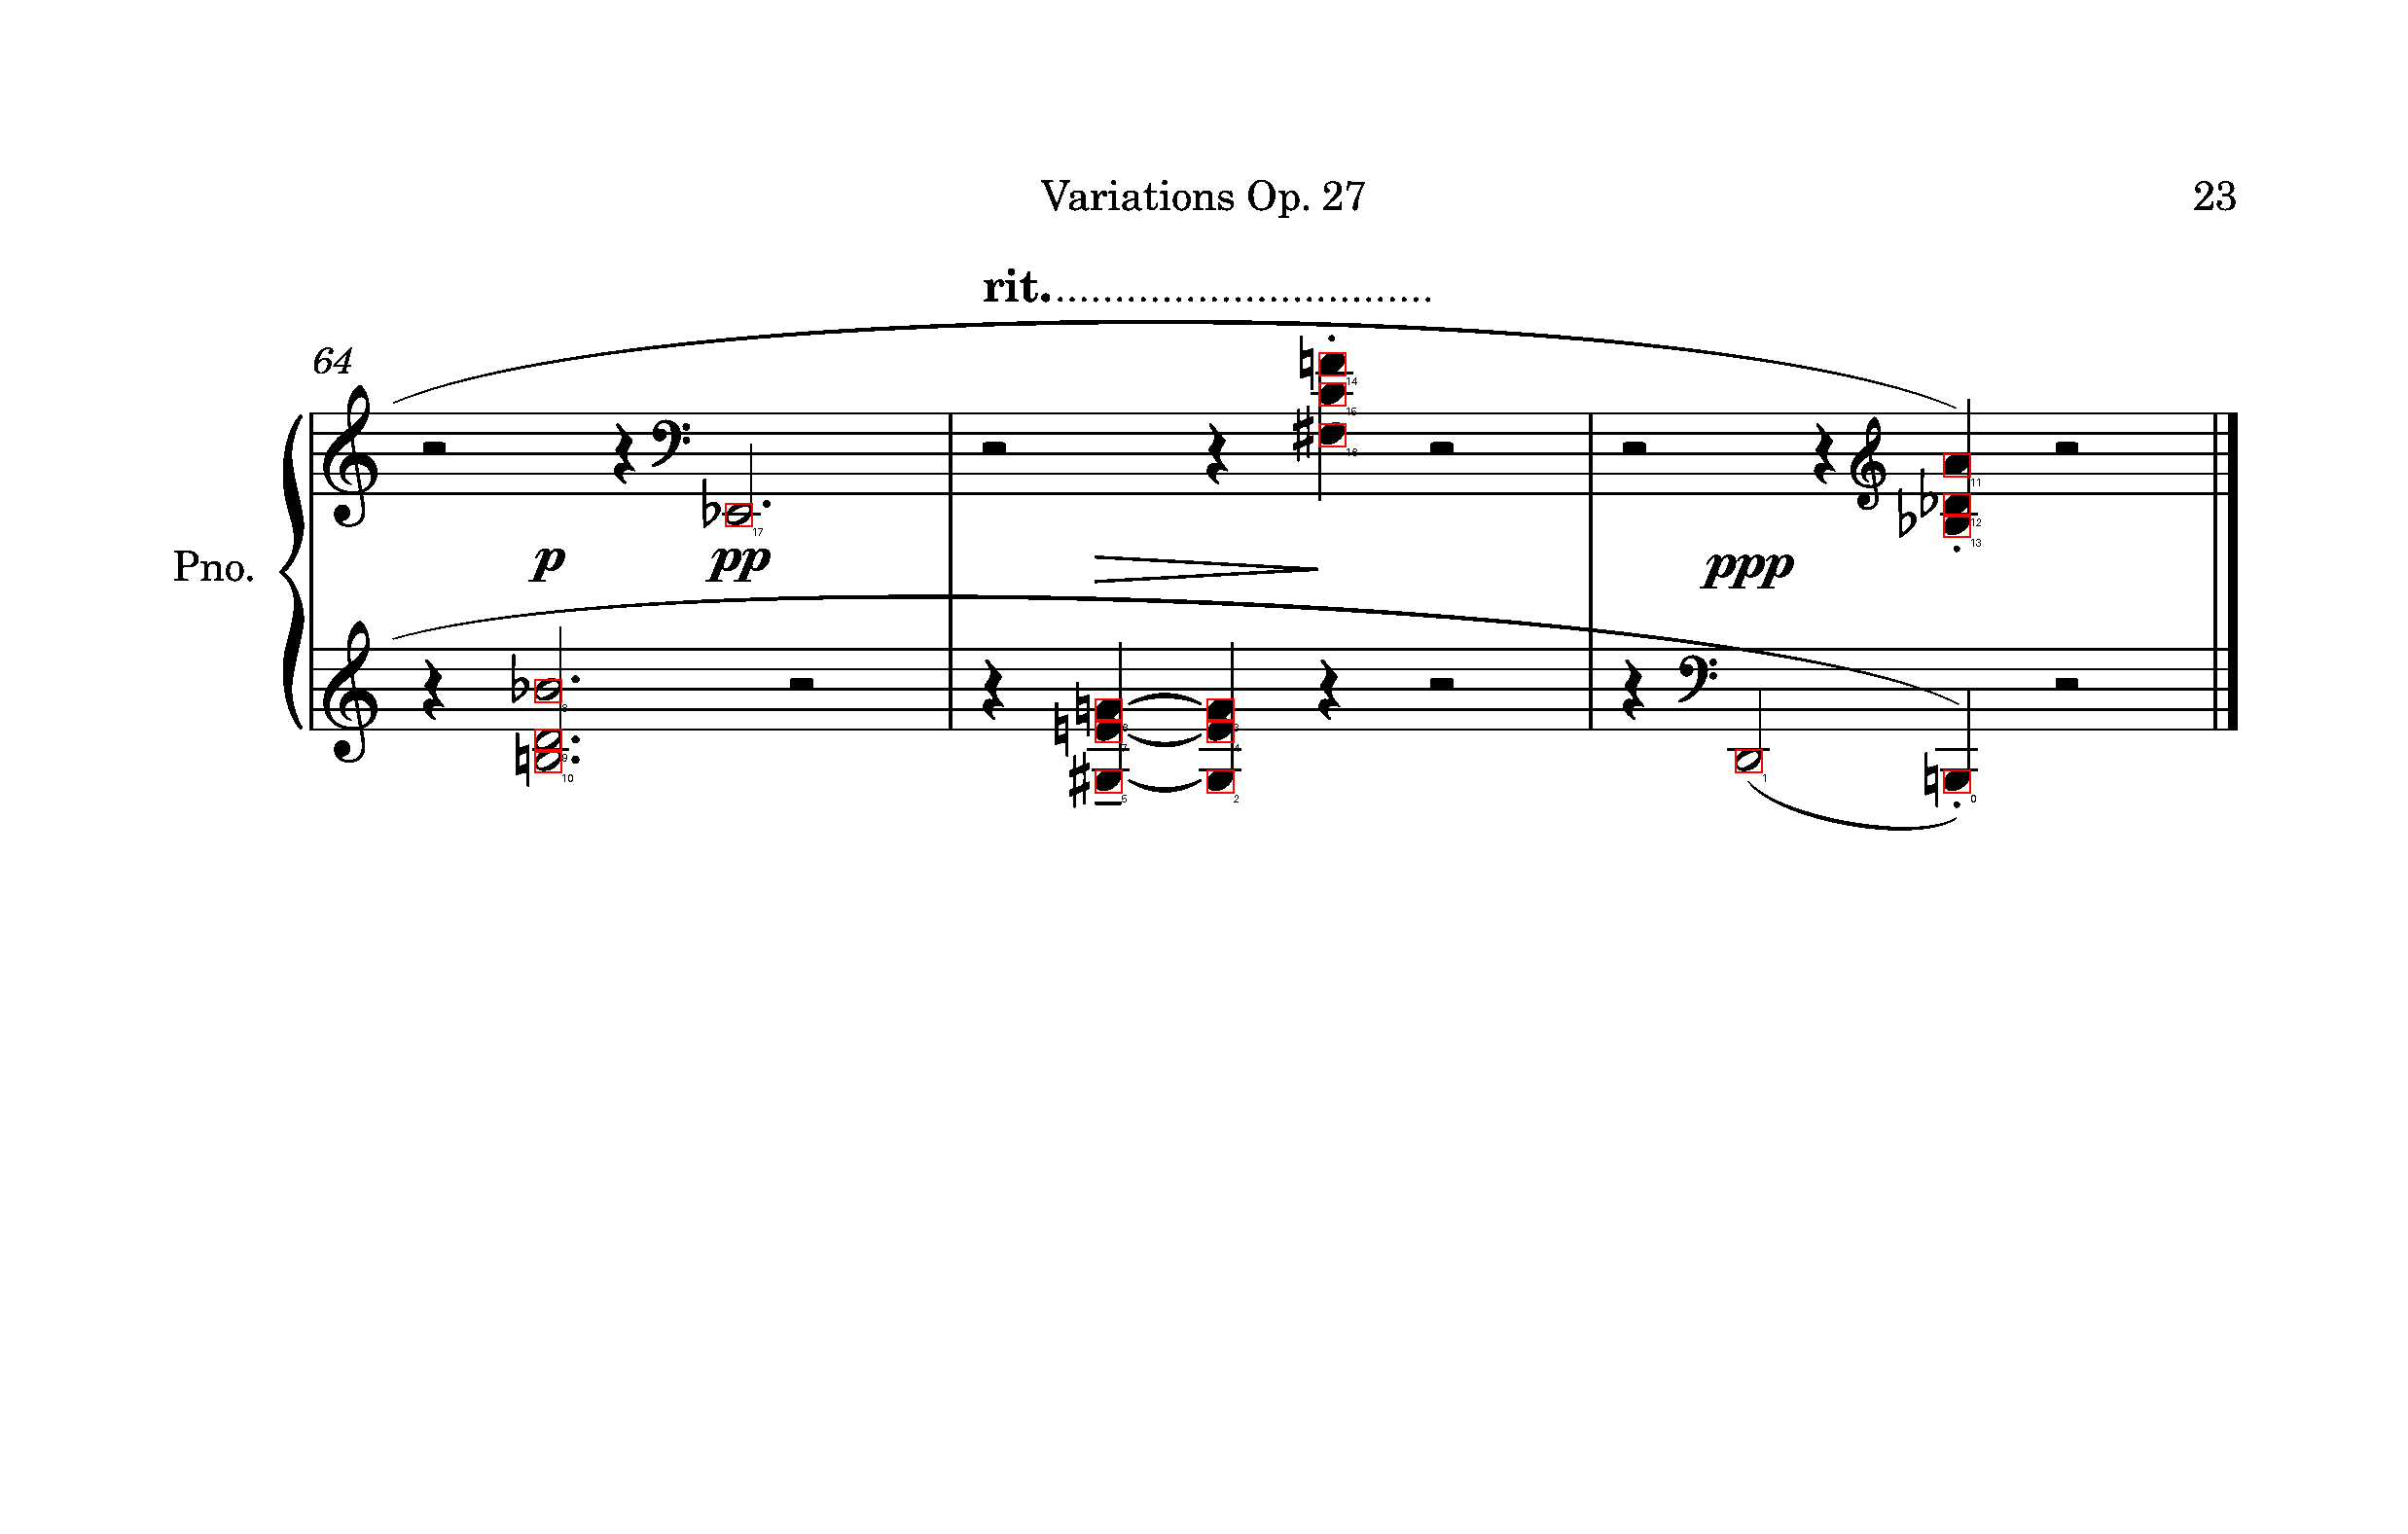

In [16]:
from PIL import Image, ImageDraw

test_image_name = key_list[5217]
test_image_path = os.path.join(doremi_dir,'Images/', test_image_name)
image = crop_top_half(test_image_path)
draw = ImageDraw.Draw(image)


# Draw bounding boxes on the image
counter = 0;
for note in final_notes:
    draw.rectangle(note.create_box(), outline="red", width=2)
    draw.text(note.create_box()[1], str(counter), fill="black")
    counter += 1
image

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

def remove_staff_lines(binary_img: np.ndarray) -> np.ndarray:
    """
    Detect and remove horizontal staff lines from the binary image input. 

    Output: 
        np.ndarray: a binary image with horizontal staff lines removed.
    """
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
    detected_stafflines = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    return cv2.subtract(binary_img, detected_stafflines)

def extract_noteheads(img_path, debut: bool) -> np.ndarray:
    # convert image to grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # assign all pixel values higher than 127 to 255 and others to 0
    _, binary_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

    # remove staff lines
    processed_img = remove_staff_lines(binary_img)

    # morphological closing to connect noteheads
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    morphed = cv2.morphologyEx(processed_img, cv2.MORPH_CLOSE, kernel, iterations=1)

    # find contours
    contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # filter out shapes that are not noteheads
    notehead_mask = np.zeros_like(morphed)
    for item in contours:
        x,y,w,h = cv2.boundingRect(item)
        ratio = w / float(h) if h else 0
        area = cv2.contourArea(item)

        if 5<w<30 and 5<h<30 and 0.5<ratio<1.5 and area>20:
            cv2.drawContours(notehead_mask, [item], -1, 255, -1)

    if debug:
        plt.figure(figsize=(6,6))
        plt.imshow(morphed, cmap='gray')
        plt.title("Morphed (staff lines out, noteheads closed)")
        plt.axis('off')
        plt.show()

    return morphed, notehead_mask

In [18]:
# morphed, mask = extract_noteheads(cropped_image, True)